# Re-implementation of the single cell processing pipeline usde in PilotWorkflow

In [13]:
import os
import sys
import inspect

# Setting working directory as home
home_dir = os.path.expanduser('~')
os.chdir(os.path.expanduser('~'))

# Adding home directory to the PYTHONPATH
sys.path.insert(0, home_dir)

from src.func import *

import numpy as np
import pandas as pd
import scanpy as sc

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

import rpy2.rinterface

# The bridge between R and Python
%load_ext rpy2.ipython

# To reload packages
%load_ext autoreload
# %autoreload 2

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.18.1 scipy==1.4.1 pandas==1.3.5 scikit-learn==0.22.2.post1 statsmodels==0.11.0 python-igraph==0.9.8 pynndescent==0.5.5


## Preprocessing

In [18]:
# Loading the data
adata = sc.read_10x_h5('data/PilotWorkflow/small/GSM4339769_C141_filtered_feature_bc_matrix.h5')

# Making the gene names unique
adata.var_names_make_unique()
adata

reading data/PilotWorkflow/small/GSM4339769_C141_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 6249 × 33539
    var: 'gene_ids', 'feature_types', 'genome'

normalizing counts per cell
    finished (0:00:00)


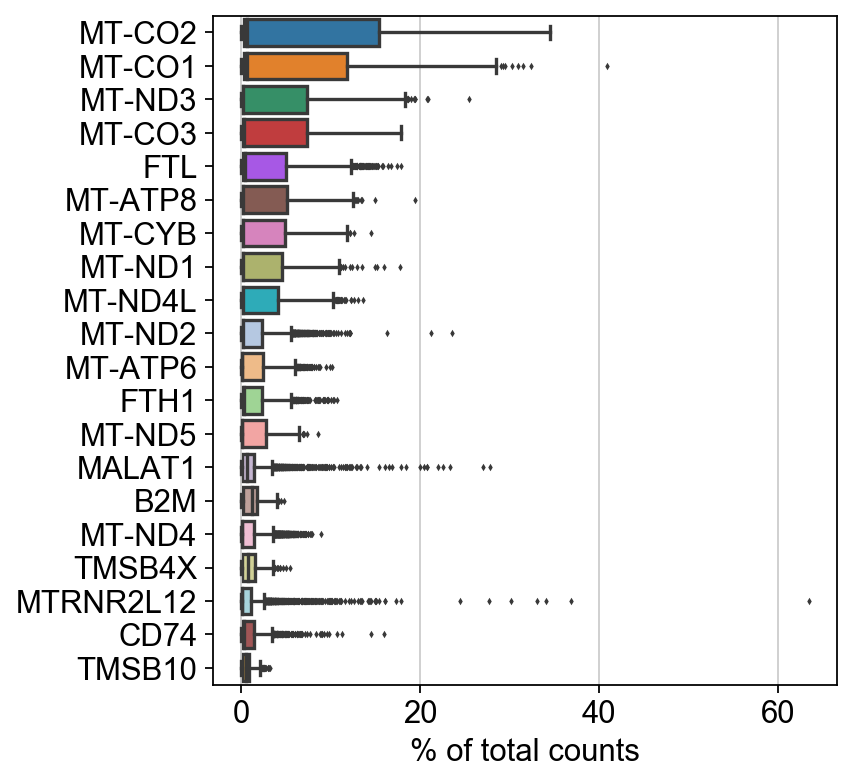

In [15]:
# Plotting genes with highest expression
sc.pl.highest_expr_genes(adata, n_top=20)

filtered out 2016 cells that have less than 200 genes expressed
filtered out 13268 genes that are detected in less than 3 cells


/home/bsc08/bsc08890/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/home/bsc08/bsc08890/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


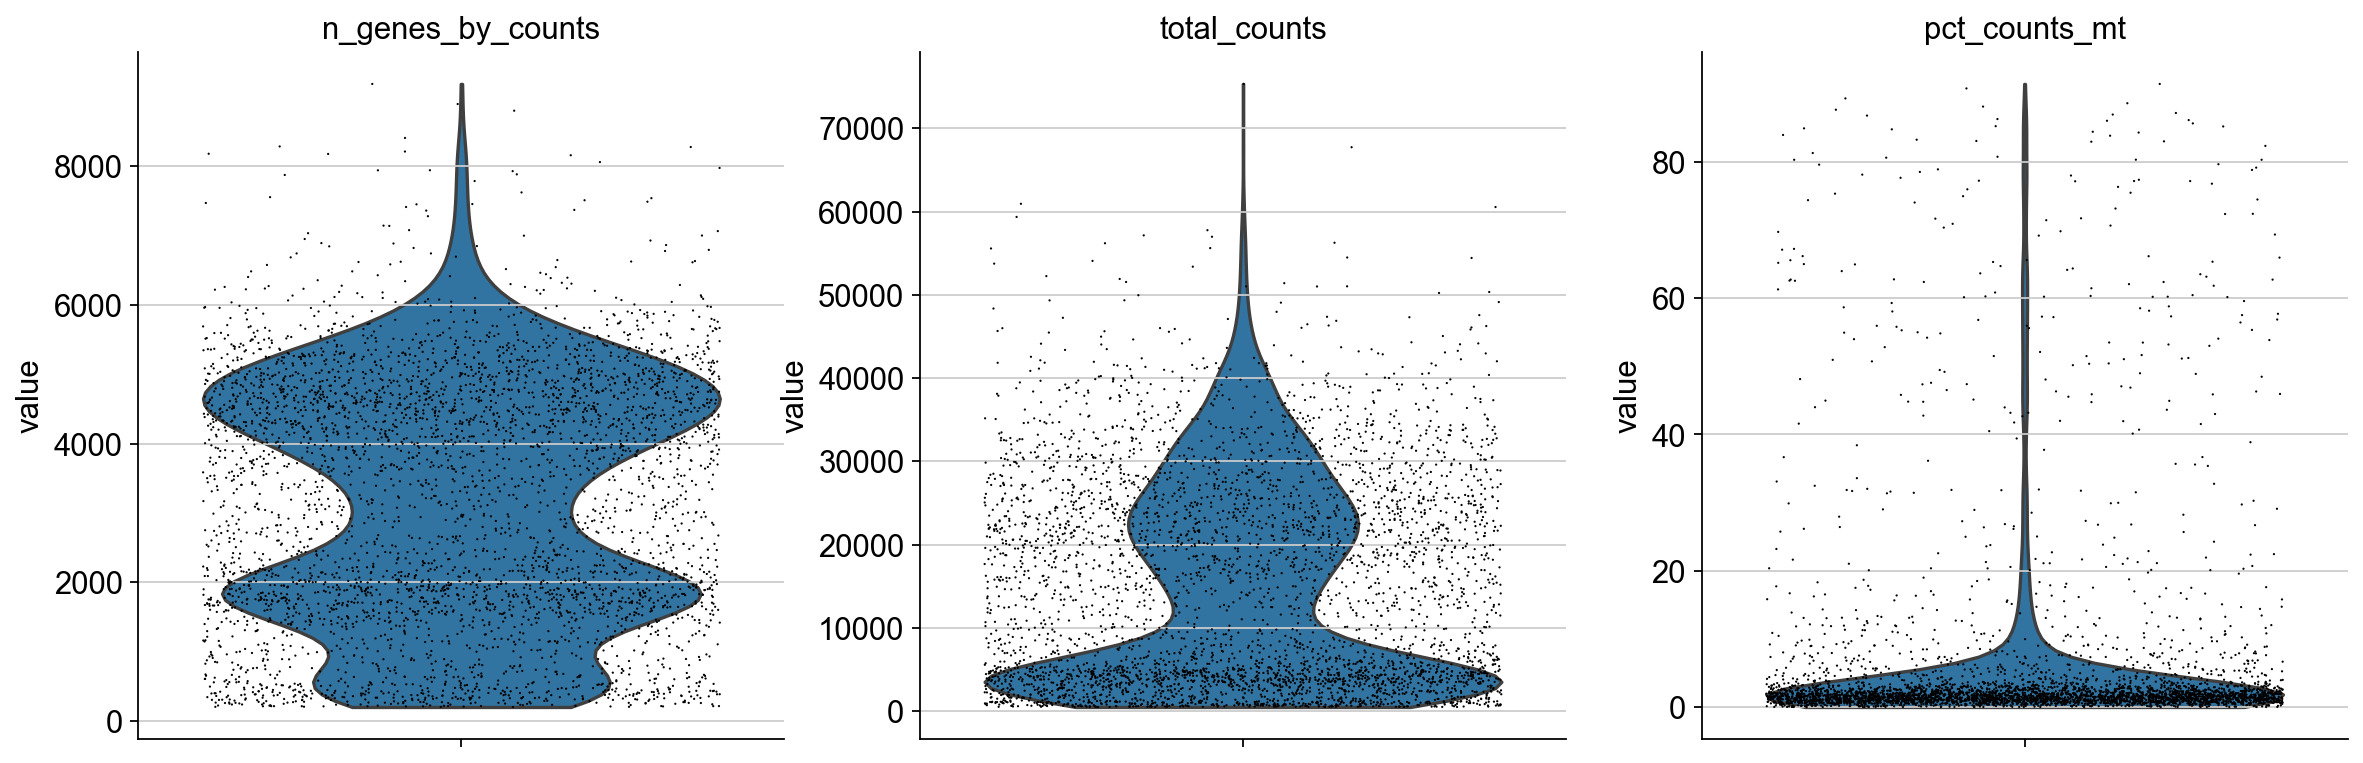

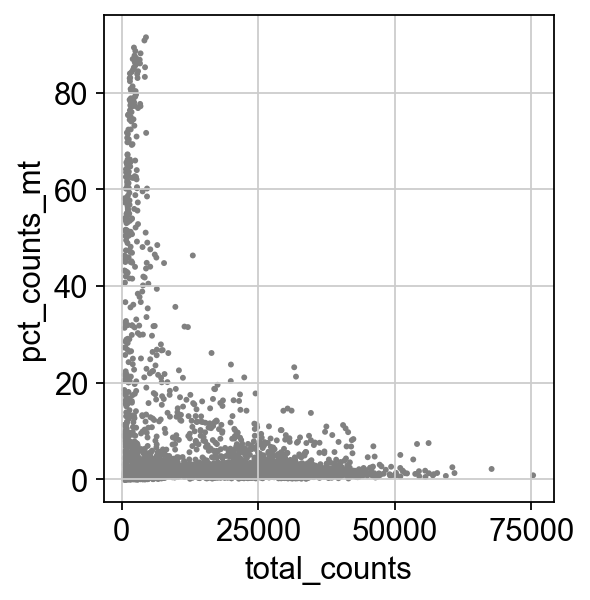

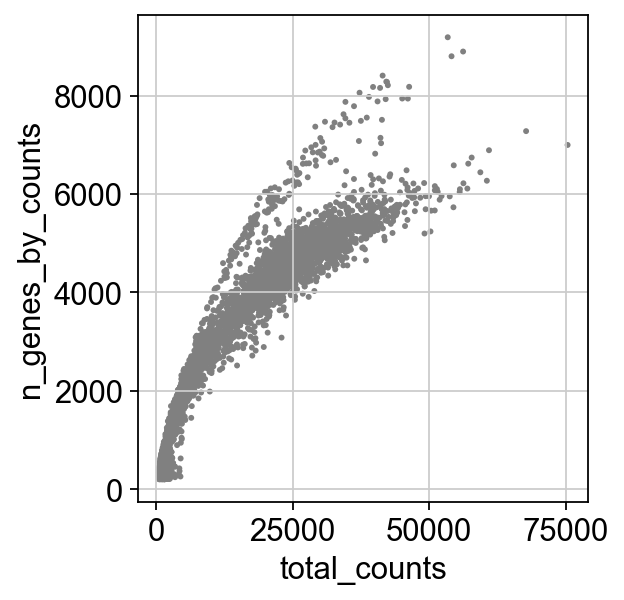

View of AnnData object with n_obs × n_vars = 1449 × 20271
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [19]:
# Initial filtering of genes and cells with low counts
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Calculating the QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Plotting the QC statistics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

# Second step of filtering
adata = adata[(adata.obs.n_genes_by_counts > 200) & (adata.obs.n_genes_by_counts < 2500), :]
adata = adata[adata.obs.pct_counts_mt < 10, :]

adata

In [5]:
# Normalizing data
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transforming data
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


/home/bsc08/bsc08890/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/home/bsc08/bsc08890/.local/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


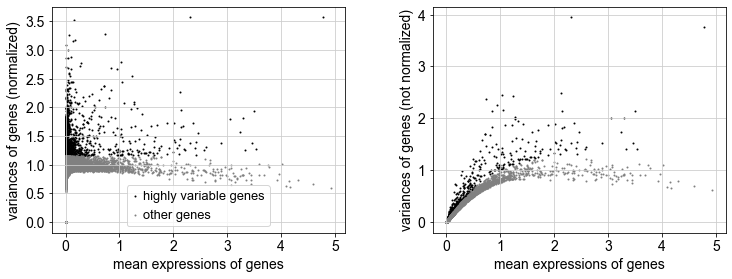

In [6]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000)

sc.pl.highly_variable_genes(adata)

In [7]:
# Keeping raw log-transformed normalized data
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [8]:
# Regressing out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:08)


In [9]:
# Scaling data to unit variance
sc.pp.scale(adata, max_value=10)

## Dimensionality reduction

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


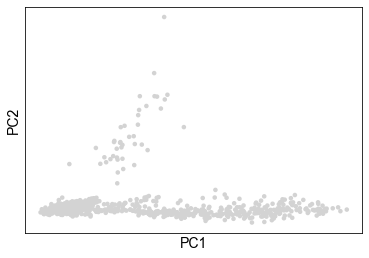

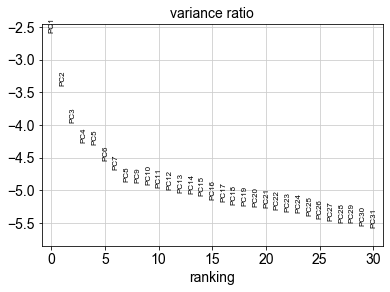

In [10]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


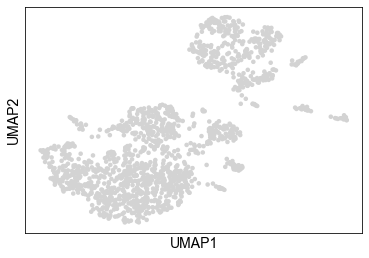

In [11]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:05)


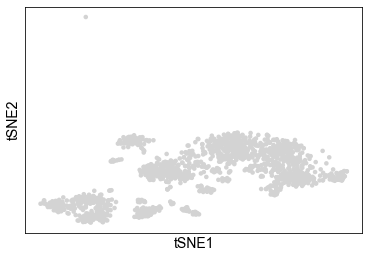

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


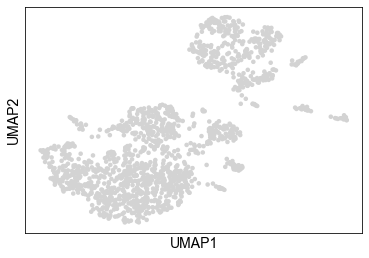

In [12]:
# Computing neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# T-SNE
sc.tl.tsne(adata)
sc.pl.tsne(adata)

# UMAP
sc.tl.umap(adata)
sc.pl.umap(adata)

## Clustering

running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


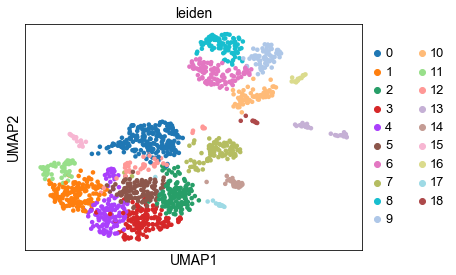

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


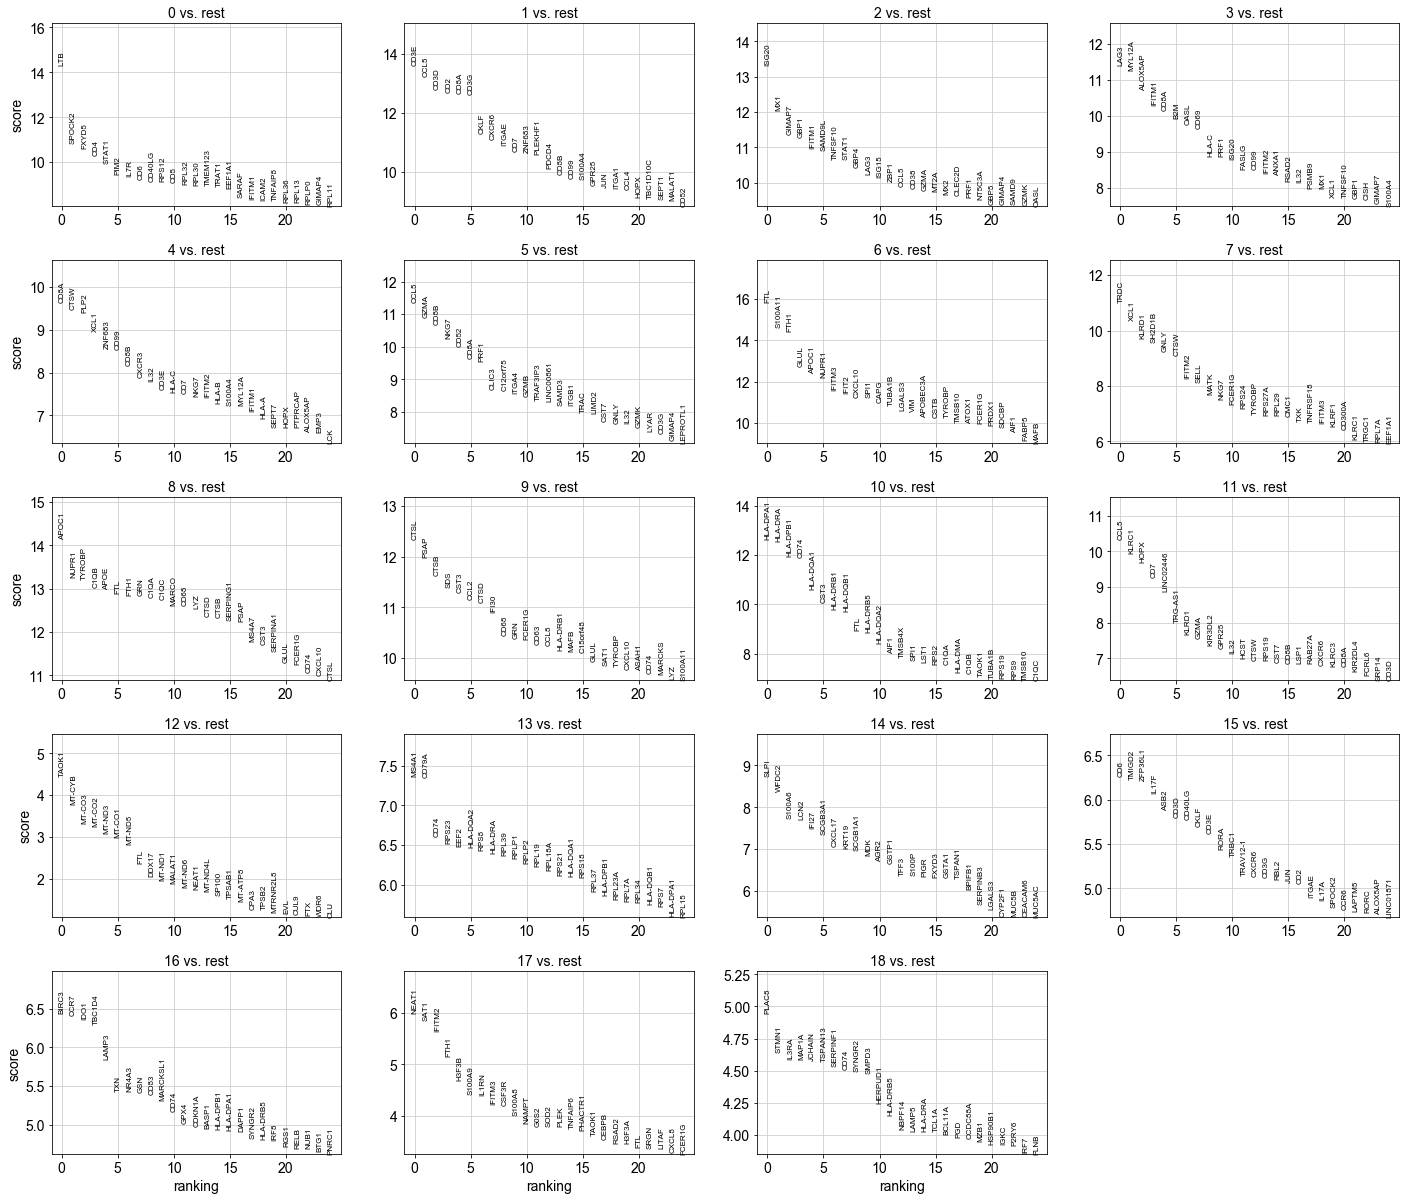

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


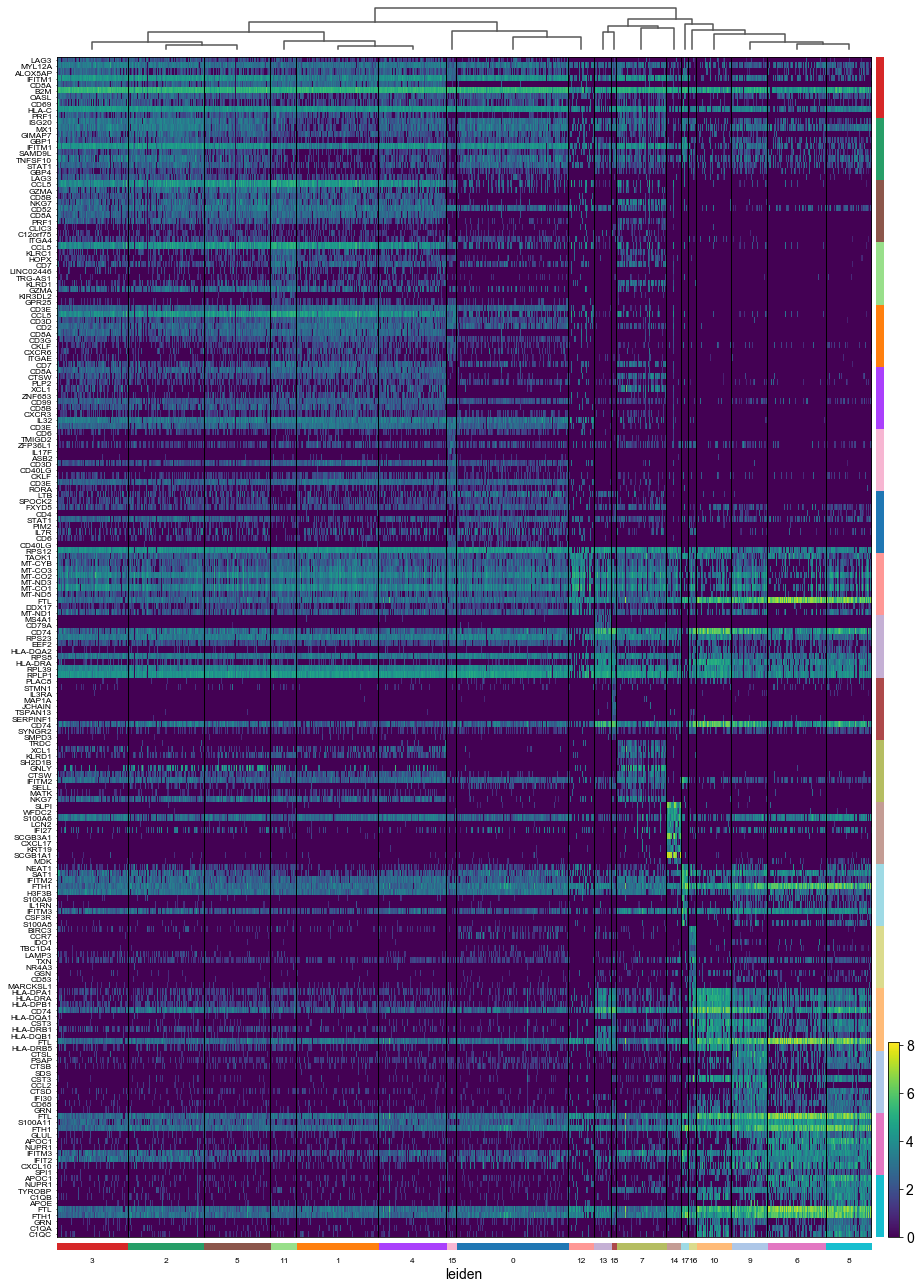

In [13]:
# Leiden clustering
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden')

# Ranking and ploting marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# Showing top 10 marker genes in each cluster
sc.pl.rank_genes_groups_heatmap(adata, show_gene_labels=True, swap_axes=True, show=True, figsize=(15, 22))

## Cell type identification

In [14]:
%%R


UsageError: %%R is a cell magic, but the cell body is empty. Did you mean the line magic %R (single %)?


### Saving HVGs for GRN inference

In [60]:
save_pickle(adata.var.index.to_list(), 'res/PilotWorkflow/data/HVG_sc.pickle')